In [ ]:
# Imports

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
saving_direc = './'


In [ ]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Normalizacion de datos
train_data = train_data / 255.
test_data = test_data / 255.

In [ ]:
print(train_data.shape)
print(test_data.shape)

(60000, 28, 28)
(10000, 28, 28)


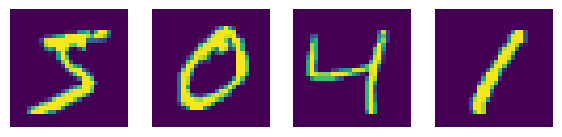

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(7,3))
axs[0].imshow(train_data[0])
axs[0].axis('off')
axs[1].imshow(train_data[1])
axs[1].axis('off')
axs[2].imshow(train_data[2])
axs[2].axis('off')
axs[3].imshow(train_data[3])
axs[3].axis('off')
plt.show()

In [ ]:
# Clases
class_names = ['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']

In [ ]:
print(train_labels.shape)

(60000,)


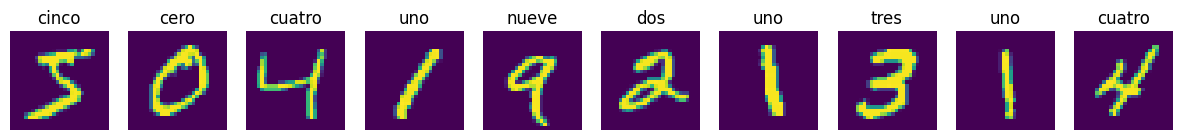

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15,7))
for i in range(10):
  axs[i].imshow(train_data[i])
  axs[i].title.set_text(class_names[train_labels[i]])
  axs[i].axis('off')
plt.show()

In [ ]:
enc = OneHotEncoder()
train_labels = train_labels[..., np.newaxis]
transformed = enc.fit_transform(train_labels)
train_labels_encoded = transformed.toarray()

In [ ]:
# Hacemos lo mismo pero ahora para las tests
enc = OneHotEncoder()
test_labels = test_labels[..., np.newaxis]
transformed = enc.fit_transform(test_labels)
test_labels_encoded = transformed.toarray()

In [ ]:
train_data = train_data[..., np.newaxis]
test_data = test_data[..., np.newaxis]

# Imprimimos para ver que como quedaron los sets ahora
print(train_data.shape)
print(test_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


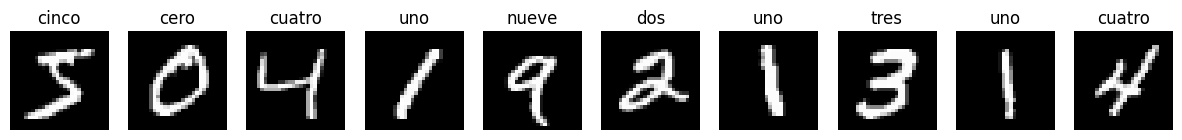

Data shape: (60000, 28, 28, 1)


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15,7))

for i in range(10):
  axs[i].imshow(train_data[i], cmap='gray')
  axs[i].title.set_text(class_names[train_labels[i][0]])
  axs[i].axis('off')
plt.show()

print('Data shape:', train_data.shape)

In [ ]:
# Eliminamos todo rastro de la primer imagen
one_image_data = train_data[0, ...]
one_image_label = train_labels_encoded[0: ,...]
train_data = train_data[1:,...]
train_labels = train_labels[1:,...]
train_labels_encoded = train_labels_encoded[1:,...]

In [ ]:
one_image_data = one_image_data[np.newaxis,...]
print(one_image_data.shape)

(1, 28, 28, 1)


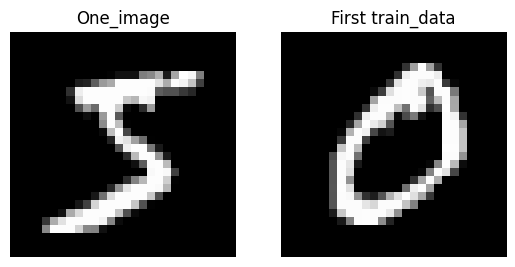

In [ ]:
# Ahora vamos a ver como esta la primer imagen en train data,
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(one_image_data.squeeze(), cmap='gray')
ax[0].title.set_text('One_image')
ax[0].axis('off')
ax[1].imshow(train_data[0].squeeze(), cmap='gray')
ax[1].title.set_text('First train_data')
ax[1].axis('off')

plt.show()

In [ ]:
# @title
# Creacion del modelo que funcionara como feature extraction
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def get_new_model(input_shape):
    input_layer = Input(shape=input_shape, name='input')
    # Block 1
    h = Conv2D(16, (3,3), activation='relu', padding='same')(input_layer)
    h = Conv2D(16, (3,3), activation='relu', padding='same')(h)
    h = MaxPool2D((2,2))(h)

    # Block 2
    h = Conv2D(32, (3,3), activation='relu', padding='same')(h)
    h = Conv2D(32, (3,3), activation='relu', padding='same')(h)
    h = MaxPool2D((2,2))(h)

    # Block 3
    h = Conv2D(64, (3,3), activation='relu', padding='same')(h)
    h = Conv2D(64, (3,3), activation='relu', padding='same')(h)

    # Embedding
    h = Conv2D(64, (1,1), activation='relu', name='embedding')(h)
    h = Dropout(0.3)(h)

    # FEATURES
    features = GlobalAveragePooling2D(name='features')(h)

    # Classifier
    output = Dense(10, activation='softmax', name='classifier')(features)

    model = Model(inputs=input_layer, outputs=output, name='CNN_GAP')

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = get_new_model(input_shape=(28,28,1))
model.summary()

Model: "CNN_GAP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Conv2D)              │ (None, 7, 7, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features                        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,602 (299.23 KB)

 Trainable params: 76,602 (299.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Definimos los checkpoints para que no corra infinitamente
def get_checkpoint_best_epoch(filepath):
  checkpoint_path = filepath
  checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                               save_weights_only=True,
                               save_best_only=True,
                               save_freq='epoch',
                               monitor='val_accuracy',
                               verbose=0)
  return checkpoint


def get_early_stopping():
  callback = EarlyStopping(monitor='val_accuracy', patience=5)
  return callback

In [ ]:
checkpoint_best_epoch = get_checkpoint_best_epoch(f'{saving_direc}checkpoint.weights.h5')
early_stopping = get_early_stopping()

In [ ]:
callbacks = [checkpoint_best_epoch, early_stopping]

history_benchmark = model.fit(x=train_data,
                                        y=train_labels_encoded,
                                        epochs=5,
                                        batch_size=100,
                                        validation_data=(test_data, test_labels_encoded),
                                        callbacks=callbacks)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 108s 176ms/step - accuracy: 0.6384 - loss: 1.0189 - val_accuracy: 0.9572 - val_loss: 0.1426
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 140s 173ms/step - accuracy: 0.9553 - loss: 0.1463 - val_accuracy: 0.9756 - val_loss: 0.0799
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 118s 197ms/step - accuracy: 0.9701 - loss: 0.0978 - val_accuracy: 0.9828 - val_loss: 0.0522
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 129s 175ms/step - accuracy: 0.9767 - loss: 0.0757 - val_accuracy: 0.9854 - val_loss: 0.0438
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 103s 171ms/step - accuracy: 0.9806 - loss: 0.0614 - val_accuracy: 0.9834 - val_loss: 0.0445


In [ ]:
model = get_new_model(input_shape=(28,28,1))
model.load_weights('/content/checkpoint.weights.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
feature_extractor = Model(
    inputs = model.input,
    outputs = model.get_layer("features").output
)
feature_extractor.trainable = False

X_feat = feature_extractor.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


In [ ]:
classifier = tf.keras.Sequential([
    model.get_layer("classifier")
])
classifier.trainable = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
y_pred = model.predict(test_data)
y_pred.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


(10000, 10)

In [ ]:
print(X_feat.shape)
print(test_labels_encoded.shape)


(10000, 64)
(10000, 10)


In [ ]:
from tensorflow import losses

In [ ]:
loss_fn = losses.CategoricalCrossentropy()

loss_value = loss_fn(test_labels_encoded, y_pred)
print(loss_value.numpy())
#loss = tf.losses.sparse_softmax_cross_entropy(labels=test_labels, logits=X_feat)

0.043819584


# GA como feature selection wrapper

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
loss_fn = losses.CategoricalCrossentropy()

# Funcion para calcular el fitness
def fintness(mask, X_feat, y, alpha=0.1, beta=0.05):
  if mask.sum() == 0:
    return 0.00001
  X_sel = tf.boolean_mask(X_feat, mask == 1, axis=1)

  y_pred = classifier(X_sel, training=False)

  error = loss_fn(y, y_pred)

  return alpha * error + beta * (tf.reduce_sum(mask) / X_feat.shape[1])

In [ ]:
def tournament_selection(pop, fintness_p, k=3):
  idx = np.random.choice(len(pop), k, replace=False)
  return pop[idx[np.argmax(fintness_p[idx])]]

In [ ]:
def crossover(p1, p2):
  mask = np.random.rand(len(p1)) < 0.5
  return np.where(mask, p1, p2)

In [ ]:
def mutate(ind, p):
  for i in range(len(ind)):
    if np.random.rand() < p:
      ind[i] = 1 - ind[i]
  return ind

In [ ]:
def genetic_algorithm(x, y, classifier_model, pop_size=40, generations=100,
                      x_min = -1, x_max = 2.0,
                      crossover_prob = 0.9,
                      mutation_prob = 0.2,
                      alpha, beta):
  x_dimension = x.shape[1]
  pupulation = np.random.randint(0, 2, size = {pop_size, x_dimension})
  best_ind = None
  best_fit = -np.inf

  for gen in range(generations):


  return best_ind, best_fit


In [ ]:
np.random.randint(0, 2, size = {40, X_feat[64]})

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
def genetic_algorithm(X, y, pop_size=40, generations=40, alpha=0.1):
  D = X.shape[1]
  mut_rate = 1.0 / D

  population = np.random.randint(0, 2, size=(pop_size, D))

  best_ind = None
  best_fit = -np.inf

  for gen in range(generations):
    fitness_r = np.array([
        fintness(ind, X, y, alpha) for ind in population
    ])
    idx = np.argmax(fitness_r)
    if fitness_r[idx] > best_fit:
      best_fit = fitness_r[idx]
      best_ind = population[idx].copy()
    new_pop = [best_ind.copy()]

    while len(new_pop) < pop_size:
      p1 = tournament_selection(population, fitness_r)
      p2 = tournament_selection(population, fitness_r)

      child = crossover(p1, p2)
      child = mutate(child, mut_rate)

      new_pop.append(child)
    population = np.array(new_pop)

    print(f"Gen{gen:02d}")
    print(f"Fitness{best_fit:.4f}")
    print(f"Features {best_ind.sum()}")
  return best_ind, best_fit


In [ ]:
print(y.shape)
print(X_feat.shape)

In [ ]:
best_mask, best_fit = genetic_algorithm(X_feat, y, 3)

print(f"Features seleccionados:", best_mask.sum())

print(f"Indices:", np.where(best_mask ==1)[0])

In [ ]:
X_selected = X_feat[:, best_mask == 1]


In [ ]:
X = X_selected
Y = test_labels_encoded

In [ ]:
X_train = X[:8000]
Y_train = Y[:8000]

X_test = X[8000:]
Y_test = Y[8000:]

In [ ]:
import tensorflow as tf
from tensorflow import keras

# MLP Model
model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[24]),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_mlp.summary()

In [ ]:
model_mlp.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
history_mlp = model_mlp.fit(X_train, Y_train, epochs=12,
                    validation_data=(X_test, Y_test))

# Vamos a hacer pruebas / valudacion


In [ ]:
# feature extractor ya definido
X_feat_train = feature_extractor.predict(one_image_data)

In [ ]:
X_selected = X_feat_train[:, best_mask == 1]


In [ ]:
X_selected.shape

In [ ]:
res = model_mlp.predict(X_selected)
print(res.shape)

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,10), res[0])
ax.set_title('Probability distribution', fontsize=20)
ax.set_xticks(np.arange(0,10))
ax.set_xticklabels(class_names, rotation=45, fontsize=14)
ax.set_xlabel('Class name', fontsize=18)
ax.set_ylabel('Probability', fontsize=18)
plt.show()

In [ ]:
# Ahora vamos a ver como esta la primer imagen en train data,
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(one_image_data.squeeze(), cmap='gray')
ax[0].title.set_text('One_image')
ax[0].axis('off')
ax[1].imshow(train_data[0].squeeze(), cmap='gray')
ax[1].title.set_text('First train_data')
ax[1].axis('off')

plt.show()
